In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
import mlflow.sklearn
import mlflow.pyfunc
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
from hyperopt import fmin, hp, tpe, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope

In [ ]:
data_df = spark.table("db_pegah.default.heart_disease")
df = data_df.toPandas()
print("data shape:", df.shape)
df.head()

data shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
#Splitting the Dataset for Training, Validating and Testing 

X = df.drop('target' , axis=1 )
y = df['target']

x_train , x_rem , y_train , y_rem = train_test_split( X , y , train_size=0.6 , random_state=42 )
x_val , x_test , y_val , y_test = train_test_split(x_rem , y_rem , test_size=0.5 , random_state=42)

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"X_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} , y_val shape: {y_val.shape}")
print(f"X_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

X shape: (303, 13), y shape: (303,)
X_train shape: (181, 13), y_train shape: (181,)
x_val shape: (61, 13) , y_val shape: (61,)
X_test shape: (61, 13), y_test shape: (61,)


In [ ]:
#for calculating metrics
def calc_metric(y_actual,y_pred,y_prob):
    accuracy = accuracy_score(y_actual,y_pred)
    precision = precision_score(y_actual,y_pred)
    recall = recall_score(y_actual,y_pred)
    f1 = f1_score(y_actual,y_pred)
    roc_auc = roc_auc_score(y_actual,y_prob)
    return accuracy , precision , recall , f1 , roc_auc

### Experiment with a Random Forest model with hyperparameter tuning

In [ ]:
# Define the search space for hyperparameters
search_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 50)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 50, 1)),
    "criterion": hp.choice("criterion", ["gini", "entropy"]),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 20, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 20, 1)),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']),
    'bootstrap': hp.choice('bootstrap', [True, False]),
}

def objective(params):
        run_name = f"RF_n={params['n_estimators']}_d={params['max_depth']}_c={params['criterion'][0]}"
        with mlflow.start_run(nested=True, run_name=run_name):
                rf_model = RandomForestClassifier(**params, random_state=42)
                rf_model.fit(x_train, y_train)
                
                y_pred_val = rf_model.predict(x_val)
                y_prob_val = rf_model.predict_proba(x_val)[:, 1]

                (accuracy , precision , recall , f1 , roc_auc) = calc_metric(y_val,y_pred_val,y_prob_val)
                mlflow.log_metric('accuracy', accuracy)
                mlflow.log_metric('precision', precision)
                mlflow.log_metric('recall', recall)
                mlflow.log_metric('f1_score', f1)
                mlflow.log_metric('roc_auc', roc_auc)
                mlflow.log_params(params)
                signature = infer_signature(x_train, rf_model.predict(x_train))
                mlflow.sklearn.log_model(rf_model, artifact_path="random_forest_model", signature=signature)
                        
                return {"loss": -roc_auc, "status": STATUS_OK}

with mlflow.start_run(run_name="RF_Hyperparameter_Tuning"):
        spark_trials = SparkTrials(parallelism=10) #for parallel hyperparameter tuning
        best_params = fmin(fn=objective, 
                                space=search_space, 
                                algo=tpe.suggest, 
                                max_evals=50, 
                                trials=spark_trials)
        mlflow.log_params(best_params)
  

mlflow.end_run()

100%|██████████| 50/50 [02:28<00:00,  2.96s/trial, best loss: -0.972943722943723]


Total Trials: 50: 50 succeeded, 0 failed, 0 cancelled.
2024/08/21 03:45:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run RF_Hyperparameter_Tuning at: adb-906463842782173.13.azuredatabricks.net/ml/experiments/2193016641927816/runs/04337ed363c1471daccaa4af9b37f42e.
2024/08/21 03:45:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: adb-906463842782173.13.azuredatabricks.net/ml/experiments/2193016641927816.


In [ ]:
# Search all runs across experiments
search_result = mlflow.search_runs(order_by=['metrics.roc_auc DESC'])

# Find the best run
best_run = search_result.iloc[0]  # Get the top run
best_auc = best_run["metrics.roc_auc"]
best_run_id = best_run["run_id"]
print(f'roc_auc of best run: {best_auc}')

# Retrieve details of the best run
best_run_details = mlflow.get_run(best_run_id)
print("Run ID:", best_run_details.info.run_id)
print("Artifact URI:", best_run_details.info.artifact_uri)
print("Status:", best_run_details.info.status)
print("Tags:", best_run_details.data.tags.get("mlflow.runName"))
print("Metrics:", best_run_details.data.metrics)
print("Params:", best_run_details.data.params) 

roc_auc of best run: 0.972943722943723
Run ID: 15d595ed82664d2fa38d27e464469573
Artifact URI: dbfs:/databricks/mlflow-tracking/2193016641927816/15d595ed82664d2fa38d27e464469573/artifacts
Status: FINISHED
Tags: RF_n=600_d=15_c=e
Metrics: {'accuracy': 0.8852459016393442, 'f1_score': 0.888888888888889, 'precision': 0.9333333333333333, 'recall': 0.8484848484848485, 'roc_auc': 0.972943722943723}
Params: {'bootstrap': 'True', 'criterion': 'entropy', 'max_depth': '15', 'max_features': 'sqrt', 'min_samples_leaf': '2', 'min_samples_split': '15', 'n_estimators': '600'}


In [ ]:
# Register the best run model and assign it the "Champion" alias
model_name = "Best_Model"
model_uri = f"runs:/{best_run_id}/random_forest_model"  
model_version = mlflow.register_model(model_uri, model_name)

client = MlflowClient()
client.set_registered_model_alias(model_name, "Champion", model_version.version)

### Load model

In [ ]:
model = mlflow.sklearn.load_model(f"models:/{model_name}@Champion")

In [ ]:
print(f'AUC: {roc_auc_score(y_train, model.predict_proba(x_train)[:, 1])}')
print(f'AUC: {roc_auc_score(y_val, model.predict_proba(x_val)[:, 1])}')
print(f'AUC: {roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])}')

AUC: 0.9833537331701345
AUC: 0.972943722943723
AUC: 0.8581081081081081


AUC: 0.972943722943723
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.93      0.88        28
           1       0.93      0.85      0.89        33

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



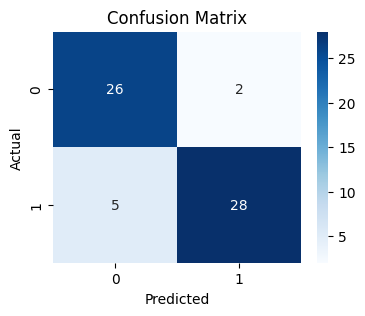

In [ ]:
y_pred_val = model.predict(x_val)
y_prob_val = model.predict_proba(x_val)[:, 1]
conf_matrix = confusion_matrix(y_val, y_pred_val)
classification_rep = classification_report(y_val, y_pred_val)
print(f'AUC: {roc_auc_score(y_val, y_prob_val)}')
print("Classification Report:\n", classification_rep)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()